In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip
/kaggle/input/facebook-recruiting-iii-keyword-extraction/SampleSubmission.csv
/kaggle/input/facebook-recruiting-iii-keyword-extraction/Test.zip


### Problem Statemtent

Suggest the tags based on the content that was there in the question posted on Stackoverflow.

**Source**: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/

#### Data Overview
Refer source - https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/

All of the data is in 2 files: Train and Test.

Train.csv contains 4 columns: Id,Title,Body,Tags.

Test.csv contains the same columns but without the Tags, which you are to predict.

Size of Train.csv - 6.75GB

Size of Test.csv - 2GB

Number of rows in Train.csv = 6034195

The questions are randomized and contains a mix of verbose text sites as well as sites related to math and programming. The number of questions from each site may vary, and no filtering has been performed on the questions (such as closed questions).

### Data Field Explaination

Dataset contains 6,034,195 rows. The columns in the table are:

Id - Unique identifier for each question

Title - The question's title

Body - The body of the question

Tags - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')

In [27]:
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import csv
from datetime import datetime
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
import matplotlib.pyplot as plt

In [3]:
if not os.path.isfile('train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    #link = 'https://drive.google.com/file/d/1fu-vaduSu2lEXSygdHVp3ViknfgCmxYV/view?usp=sharing'
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('../input/facebook-recruiting-iii-keyword-extraction/Train.zip', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

180000 rows
360000 rows
540000 rows
720000 rows
900000 rows
1080000 rows
1260000 rows
1440000 rows
1620000 rows
1800000 rows
1980000 rows
2160000 rows
2340000 rows
2520000 rows
2700000 rows
2880000 rows
3060000 rows
3240000 rows
3420000 rows
3600000 rows
3780000 rows
3960000 rows
4140000 rows
4320000 rows
4500000 rows
4680000 rows
4860000 rows
5040000 rows
5220000 rows
5400000 rows
5580000 rows
5760000 rows
5940000 rows
6120000 rows
Time taken to run this cell : 0:04:57.408387


In [4]:
# checking for total no.of rows
if os.path.isfile('train.db'):
    start = datetime.now()
    conn = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT COUNT(*) FROM DATA""",conn)
    print("Number of rows in db: ",num_rows['COUNT(*)'].values[0])
    conn.close() # closing db connection
    print("Time taken :",datetime.now() - start)
else:
    print('train.db file not found')

Number of rows in db:  6034196
Time taken : 0:00:02.249336


In [5]:
#checking for duplicates
if os.path.isfile('train.db'):
    start = datetime.now()
    conn = sqlite3.connect('train.db')
    df_dup = pd.read_sql_query('SELECT Title,Body,Tags,COUNT(*) as dup FROM DATA GROUP BY Title,Body,Tags',conn)
    conn.close()
    print("Time taken: ",datetime.now() - start)
    print('duplicate questions: ',num_rows['COUNT(*)'].values[0]-df_dup.shape[0])
    
else:
    print("train.db not found!!")

Time taken:  0:01:14.853136
duplicate questions:  1827881


In [6]:
# occurence
df_dup.dup.value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: dup, dtype: int64

In [7]:
df_dup.head()

,Title,Body,Tags,dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [8]:
df_dup.info(show_counts = True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206315 entries, 0 to 4206314
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   Title   4206315 non-null  object
 1   Body    4206315 non-null  object
 2   Tags    4206308 non-null  object
 3   dup     4206315 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 128.4+ MB


In [9]:
df_dup["tag_count"] = df_dup["Tags"].apply(
    lambda text: len(text.split(" ")) if text != None else 0 
)
df_dup.tag_count.value_counts()

3    1206157
2    1111706
4     814996
1     568291
5     505158
0          7
Name: tag_count, dtype: int64

In [10]:
df_dup.head()

,Title,Body,Tags,dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [11]:
# creating new db, removing duplicates
if not os.path.isfile('../input/d/elemento/facebook-recruiting-iii-keyword-extraction/train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train', disk_dup)

In [12]:
if not os.path.isfile('../input/d/elemento/facebook-recruiting-iii-keyword-extraction/train_no_dup.db'):
    start = datetime.now()
    conn = sqlite3.connect('train_no_dup.db')
    tag_df = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", conn)
    conn.close()
    # dropping unwanted column
    tag_df.drop(tag_df.index[0], inplace = True)
    #tag_df.head()
    print("Time taken: ",datetime.now() - start)
    
    
else:
    print("train_no_dup.db not found!!")
    

Time taken:  0:00:07.521991


In [13]:
tag_df.head()

,Tags
1,c# silverlight data-binding
2,c# silverlight data-binding columns
3,jsp jstl
4,java jdbc
5,facebook api facebook-php-sdk


In [14]:
'''
# Connect to the database file
conn = sqlite3.connect('train_no_dup.db')

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

# Execute a query to retrieve data from a table
cursor.execute('SELECT * FROM no_dup_train')

# Fetch all rows from the result set
rows = cursor.fetchall()

# Print the data
for row in rows:
    print(row)

# Close the database connection
conn.close() '''


"\n# Connect to the database file\nconn = sqlite3.connect('train_no_dup.db')\n\n# Create a cursor object to execute SQL queries\ncursor = conn.cursor()\n\n# Execute a query to retrieve data from a table\ncursor.execute('SELECT * FROM no_dup_train')\n\n# Fetch all rows from the result set\nrows = cursor.fetchall()\n\n# Print the data\nfor row in rows:\n    print(row)\n\n# Close the database connection\nconn.close() "

### Analysis of tags

In [15]:
no_dup["tag_count"] = df_dup["Tags"].apply(
    lambda text: len(text.split(" ")) if text != None else 0 
)
df_dup.tag_count.value_counts()

3    1206157
2    1111706
4     814996
1     568291
5     505158
0          7
Name: tag_count, dtype: int64

In [16]:
tag_df['Tags'] = tag_df['Tags'].fillna('')  # Replace missing values with an empty string

# Importing & Initializing the "CountVectorizer" object, which is scikit-learn's bag of words tool.
# By default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())

# fit_transform() does two functions
# First, it fits the model & learns the vocabulary
# Second, it transforms our training data into feature vectors. 
# The input to fit_transform should be a list of strings.
tag_vec = vectorizer.fit_transform(tag_df['Tags'])

In [17]:
print("Number of data points :", tag_vec.shape[0])
print("Number of unique tags :", tag_vec.shape[1])

Number of data points : 4206314
Number of unique tags : 42048


In [18]:
#get feature names
tags = vectorizer.get_feature_names_out()
print(tags[:10])

['.a' '.app' '.asp.net-mvc' '.aspxauth' '.bash-profile' '.class-file'
 '.cs-file' '.doc' '.drv' '.ds-store']


In [21]:
# accessing sparse matrix (tag_vec) elements. storing the document term matrix in a dictionary.
freqs = tag_vec.sum(axis = 0).A1 
# calculates the sum of all elements along the vertical axis (axis=0) of the sparse matrix.
# .A1 is used to convert the resulting sum matrix to a 1-D NumPy array.
result = dict(zip(tags, freqs))
#zip(tags, freqs) creates an iterator that pairs each tag with its corresponding frequency value from the freqs array.

In [24]:
# Saving this dictionary to csv files.
if not os.path.isfile('../input/d/elemento/facebook-recruiting-iii-keyword-extraction/tag_counts_dict_vec.csv'):
    with open('tag_counts_dict_vec.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tags_df = pd.read_csv("/kaggle/working/tag_counts_dict_vec.csv", names=['Tags', 'Counts'])
tags_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [25]:
# sorting
tags_df_sorted = tags_df.sort_values(['Counts'], ascending=False)
tags_counts = tags_df_sorted['Counts'].values

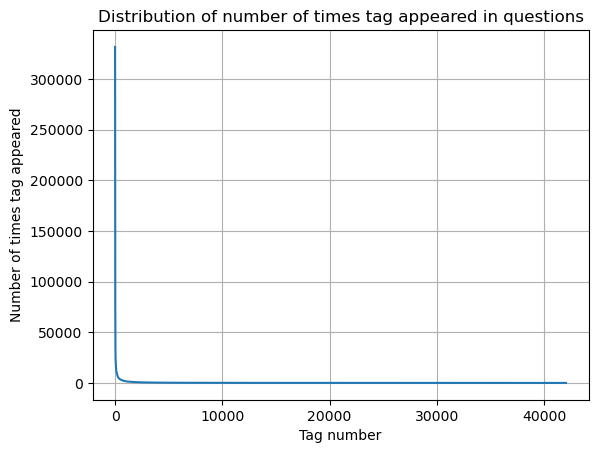

In [28]:
plt.plot(tags_counts)
plt.title("Distribution of number of times tag appeared in questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()